In [5]:
from Samplers.sampler_test import *
from Samplers.plotting import *
from Samplers.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, invwishart, dirichlet
from tqdm import tqdm
import matplotlib.patches as patches
import matplotlib.pyplot as plt

data = pd.read_csv('data/NHANES_adults_data_preprocessed.csv')
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
filtered_data = data[(data['sex'] == 2) & (data['age'] >= 40) & (data['age'] < 60)]
cleaned_data = filtered_data[
    (filtered_data['bmi'] >= 10) & (filtered_data['bmi'] <= 80) &
    (filtered_data['sbp'] >= 70) & (filtered_data['sbp'] <= 270)
]
bmi_sbp_data = cleaned_data[['bmi', 'sbp']].dropna()


In [6]:
mean_bmi = bmi_sbp_data['bmi'].mean()
mean_sbp = bmi_sbp_data['sbp'].mean()
std_bmi = bmi_sbp_data['bmi'].std()
std_sbp = bmi_sbp_data['sbp'].std()
bmi_sbp_data.loc[:, 'bmi'] = (bmi_sbp_data['bmi'] - mean_bmi) / std_bmi
bmi_sbp_data.loc[:, 'sbp'] = (bmi_sbp_data['sbp'] - mean_sbp) / std_sbp
bmi_bounds = (np.array([18, 25, 30, np.inf])-mean_bmi)/std_bmi
sbp_bounds = (np.array([140, 160, np.inf])-mean_sbp)/std_sbp

corners = np.array([
    [bmi_bounds[0] - 0.05, sbp_bounds[0] - 0.05],
    [bmi_bounds[2] + 0.05, sbp_bounds[0] - 0.05],
    [bmi_bounds[0] - 0.05, sbp_bounds[1] + 0.05],
    [bmi_bounds[2] - 0.05, sbp_bounds[1] + 0.05]
])
corners


array([[-1.64292516,  0.89215523],
       [ 0.06717543,  0.89215523],
       [-1.64292516,  2.09056188],
       [-0.03282457,  2.09056188]])

In [7]:
from scipy.spatial.distance import pdist

def h1(mu):
    return np.min(pdist(mu))

def h2(mu):
    """
    Returns 1 if unique, 0 otherwise.
    """
    # Extract BMI and SBP values from mu
    bmi = mu[:, 0]
    sbp = mu[:, 1]
    
    # Use np.digitize to find interval indices for BMI and SBP
    bmi_blocks = np.digitize(bmi, bins=bmi_bounds)
    sbp_blocks = np.digitize(sbp, bins=sbp_bounds)
    
    # Combine BMI and SBP block indices into tuples
    blocks = set(zip(bmi_blocks, sbp_blocks))
    
    # If all blocks are unique, return 1; otherwise, return 0
    return 1 if len(blocks) == len(mu) else 0


Running for N = 500


Sampling: 100%|██████████| 2000/2000 [00:08<00:00, 224.04it/s]



Running for N = 1000


Sampling: 100%|██████████| 2000/2000 [00:18<00:00, 110.23it/s]



Running for N = 2000


Sampling: 100%|██████████| 2000/2000 [00:25<00:00, 79.16it/s]



Running for N = 3000


Sampling: 100%|██████████| 2000/2000 [00:38<00:00, 51.75it/s]



Running for N = 5000


Sampling: 100%|██████████| 2000/2000 [01:00<00:00, 33.08it/s]



Running for N = 8000


Sampling: 100%|██████████| 2000/2000 [01:37<00:00, 20.44it/s]



Running for N = 10322


Sampling: 100%|██████████| 2000/2000 [02:07<00:00, 15.65it/s]


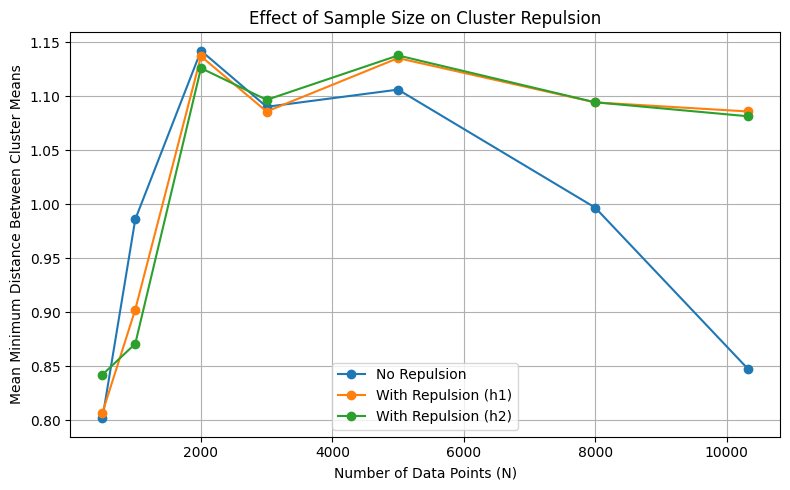

In [8]:
#sample size comparison plot
K = 4
num_iterations = 2000
burn_in = 500
sig = 0.1
all_N = [500,1000, 2000, 3000, 5000,8000,10322]

repulsion_noh = []
repulsion_withh1 = []
repulsion_withh2 = []

for N in all_N:
    print(f"\nRunning for N = {N}")
    # Randomly sample N rows from the NumPy array
    np.random.seed(42)  # Ensure reproducibility
    indices = np.random.choice(bmi_sbp_data.shape[0], size=N, replace=False)
    X_subset = bmi_sbp_data.iloc[indices]
    
    # --- Gibbs Sampler (no repulsion) ---
    samples_noh = gibbs_sampler_gmm_multivariate(X_subset, K, num_iterations, burn_in)
    mu_noh = np.array([s[1] for s in samples_noh])
    repulsion_noh.append(mu_distance(mu_noh, mode='min'))

    # --- Gibbs with Repulsion (h1) ---
    samples_withh1 = bayesian_repulsive_randomwalk(X_subset, K, num_iterations, h1, burn_in, sig, mu=corners)
    mu_withh1 = np.array([s[1] for s in samples_withh1])
    repulsion_withh1.append(mu_distance(mu_withh1, mode='min'))
    # --- Gibbs with Repulsion (h2) ---
    samples_withh2 = bayesian_repulsive_randomwalk(X_subset, K, num_iterations, h2, burn_in, sig, mu=corners)
    mu_withh2 = np.array([s[1] for s in samples_withh2])
    repulsion_withh2.append(mu_distance(mu_withh2, mode='min'))

# --- Plot Results ---
plt.figure(figsize=(8, 5))
plt.plot(all_N, repulsion_noh, label='No Repulsion', marker='o')
plt.plot(all_N, repulsion_withh1, label='With Repulsion (h1)', marker='o')
plt.plot(all_N, repulsion_withh2, label='With Repulsion (h2)', marker='o')
plt.xlabel('Number of Data Points (N)')
plt.ylabel('Mean Minimum Distance Between Cluster Means')
plt.title('Effect of Sample Size on Cluster Repulsion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Sampling: 100%|██████████| 2000/2000 [02:01<00:00, 16.45it/s]


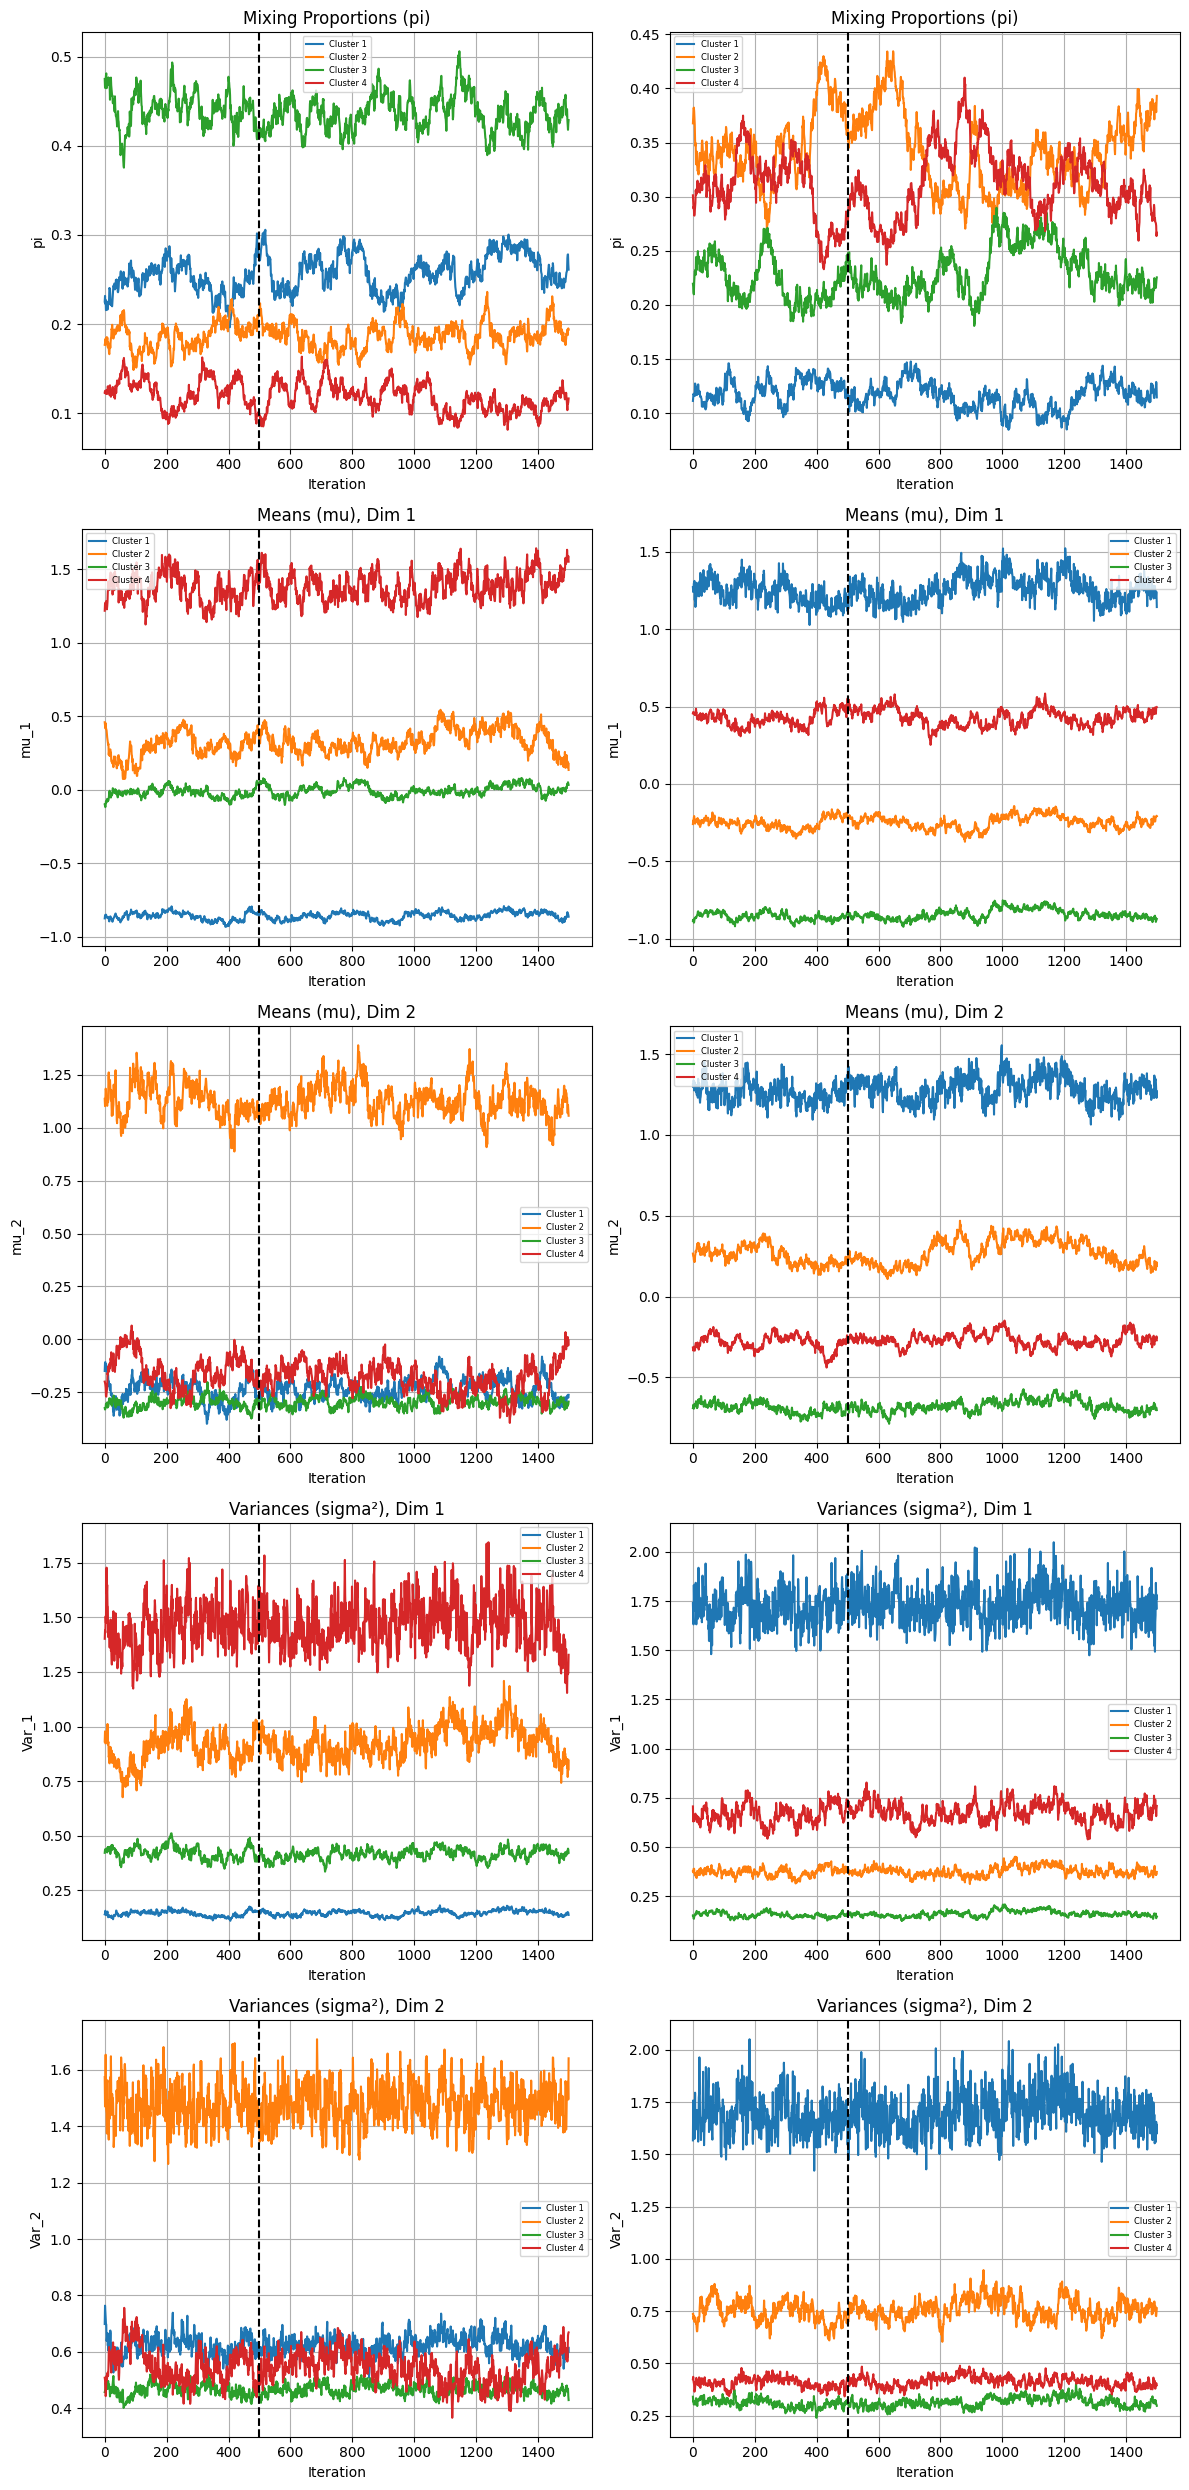

In [9]:
#gibbs sampler trace plots
np.random.seed(42)
# Parameters
# num_runs = 2
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
num_runs = 2
all_run_samples = []

for i in range(num_runs):
    run_samples = gibbs_sampler_gmm_multivariate(X, K, num_iterations, 500)
    all_run_samples.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




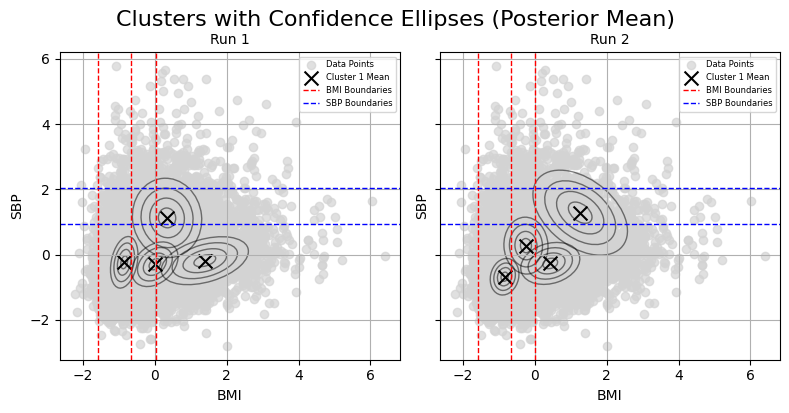

In [10]:
ellipse_mean(all_run_samples, X, bmi_bounds, sbp_bounds, burn_in=500)

Running Gibbs Sampler for sigma = 0.01


Sampling: 100%|██████████| 2000/2000 [02:05<00:00, 15.95it/s]


Running Gibbs Sampler for sigma = 0.05


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.21it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.22it/s]


Running Gibbs Sampler for sigma = 0.15


Sampling: 100%|██████████| 2000/2000 [02:05<00:00, 15.97it/s]


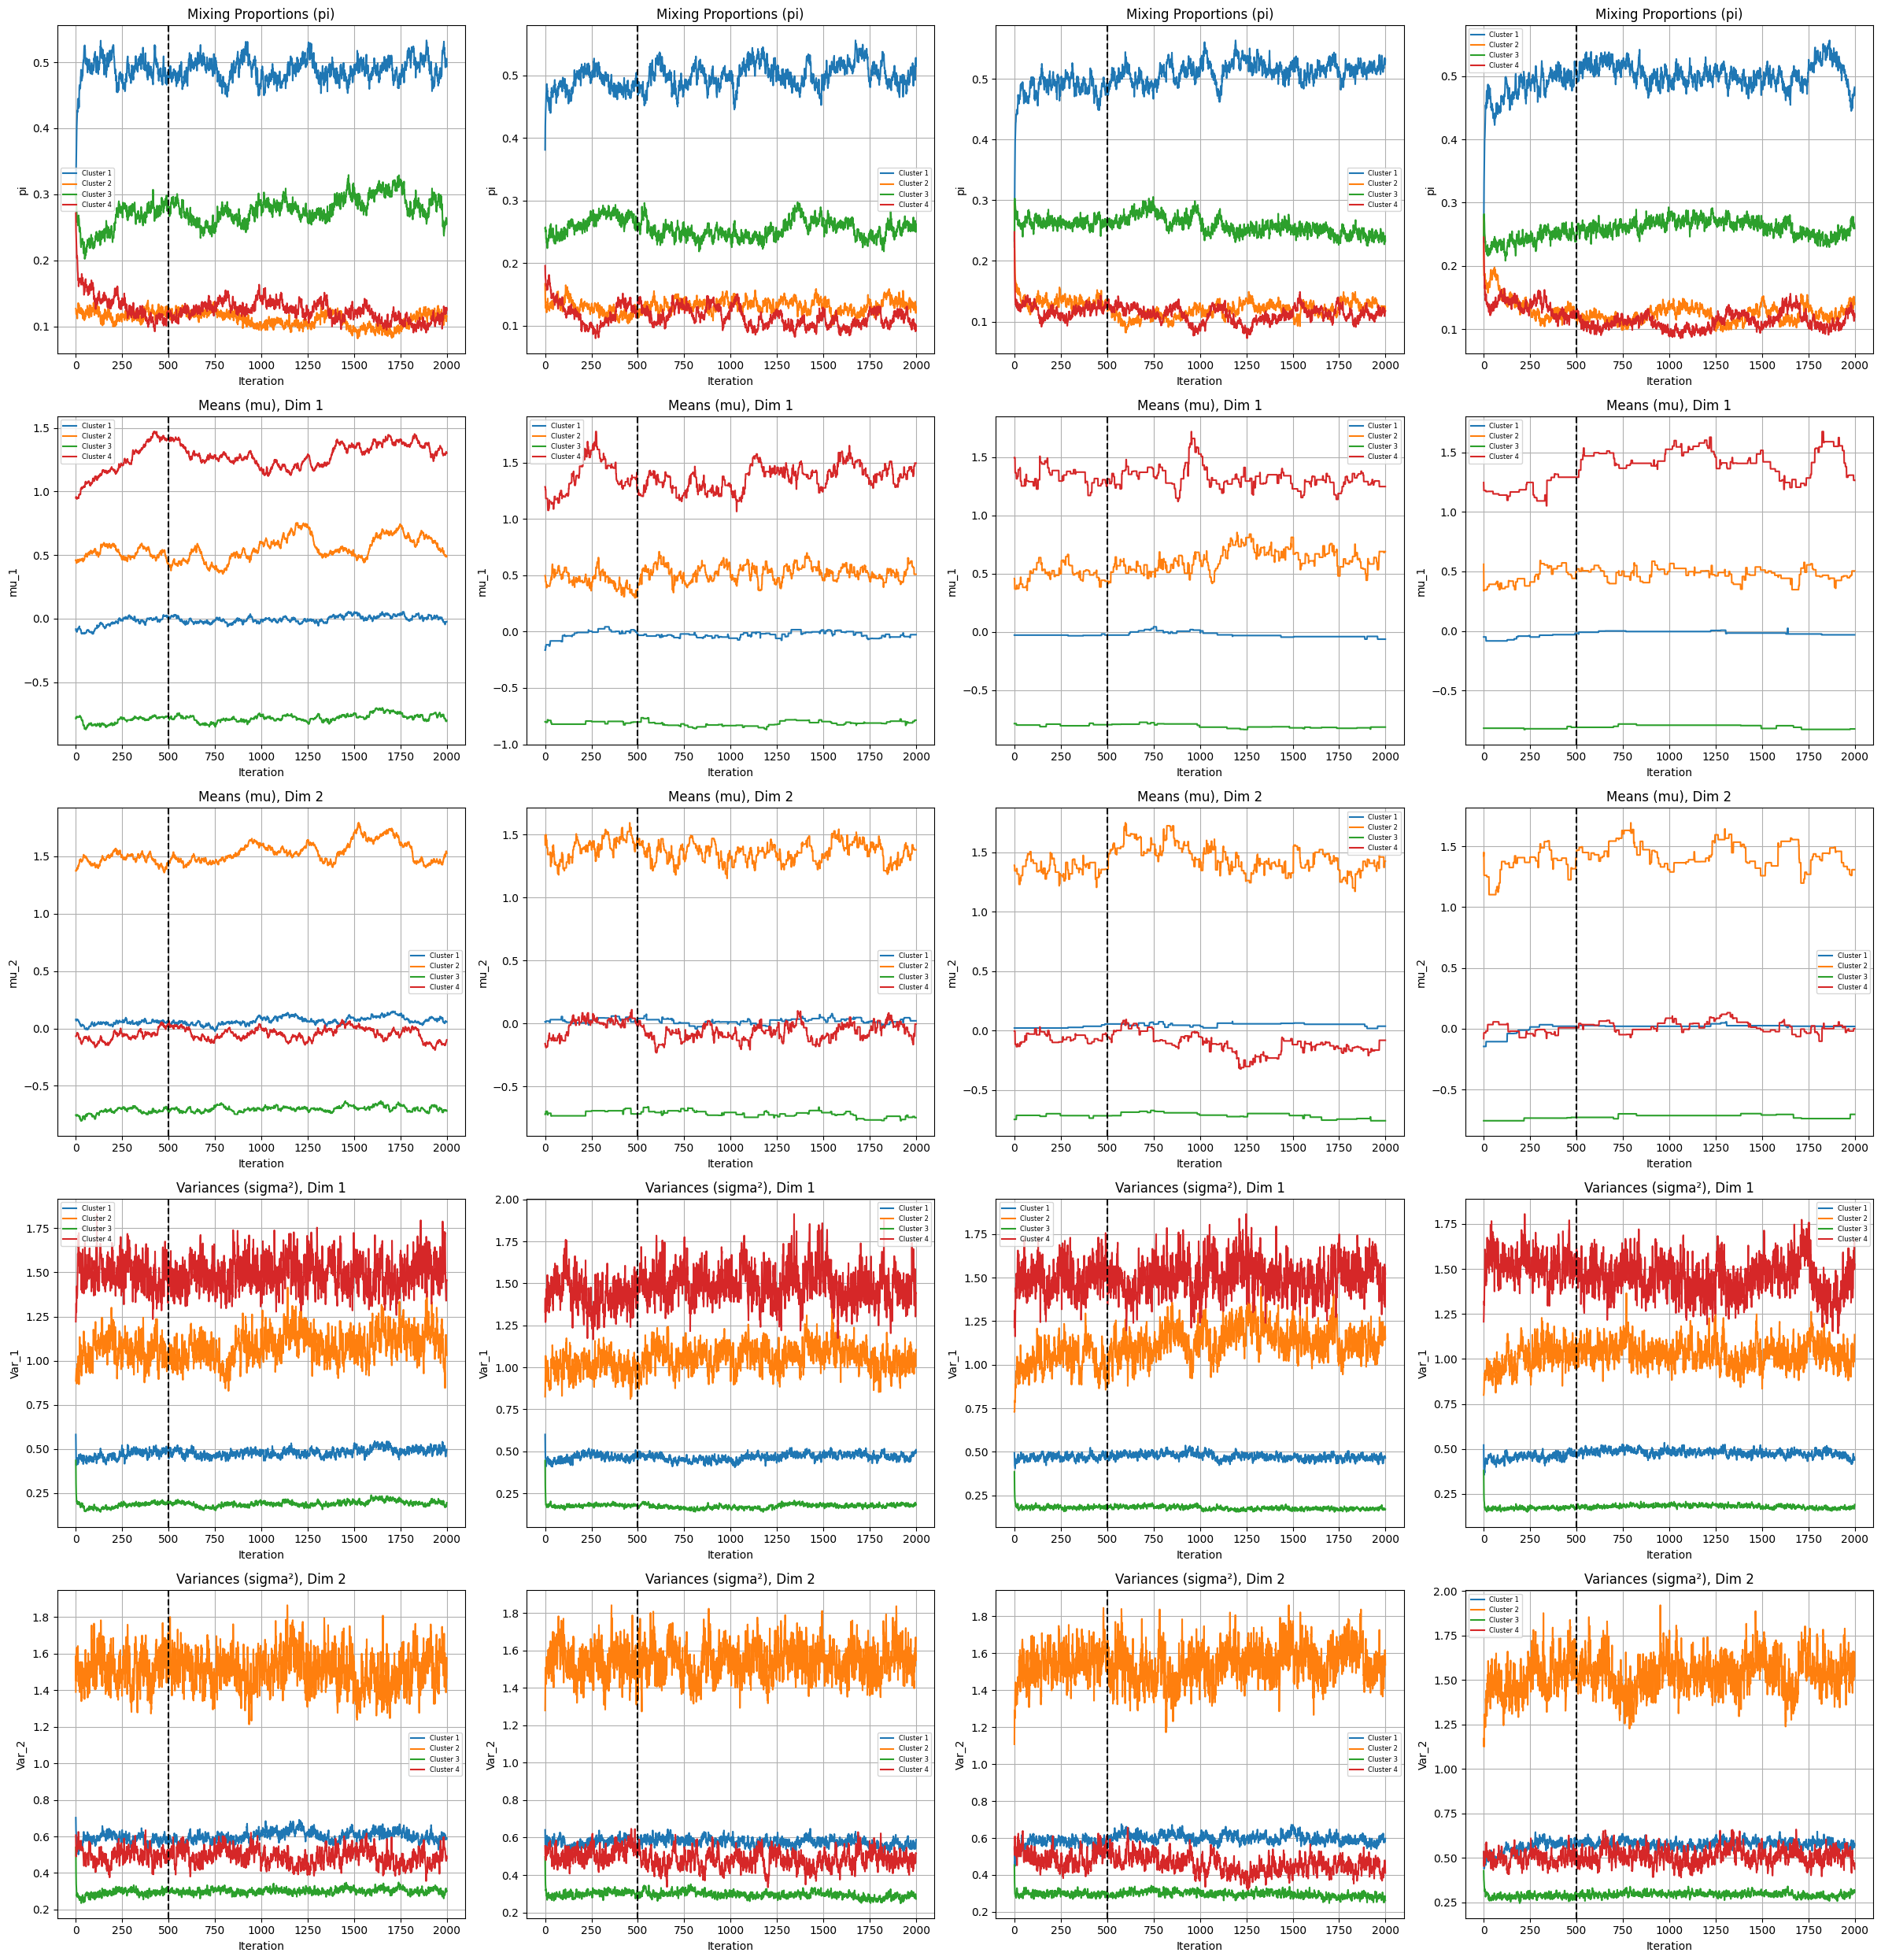

In [12]:

num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.01, 0.05, 0.1, 0.15]
num_runs = len(sigma_vals)
all_run_samples_h1 = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h1, 0, sig, mu = corners)
    all_run_samples_h1.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples_h1[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()


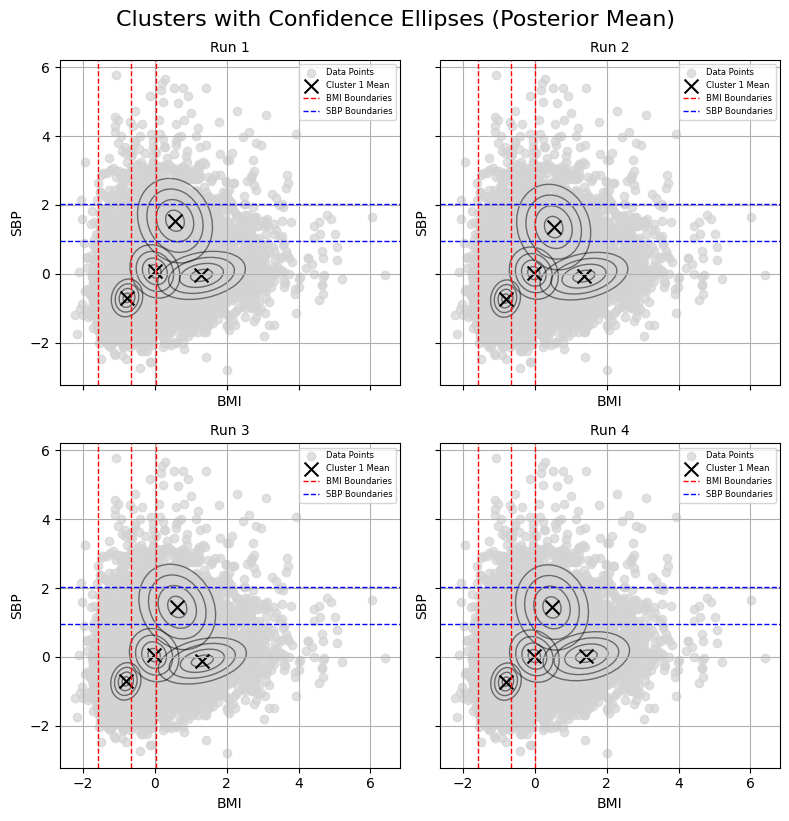

In [13]:
ellipse_mean(all_run_samples_h1, X, bmi_bounds, sbp_bounds, burn_in=500)

Running Gibbs Sampler for sigma = 0.06


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.25it/s]


Running Gibbs Sampler for sigma = 0.065


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.19it/s]


Running Gibbs Sampler for sigma = 0.07


Sampling: 100%|██████████| 2000/2000 [02:07<00:00, 15.72it/s]


Running Gibbs Sampler for sigma = 0.1


Sampling: 100%|██████████| 2000/2000 [02:03<00:00, 16.18it/s]


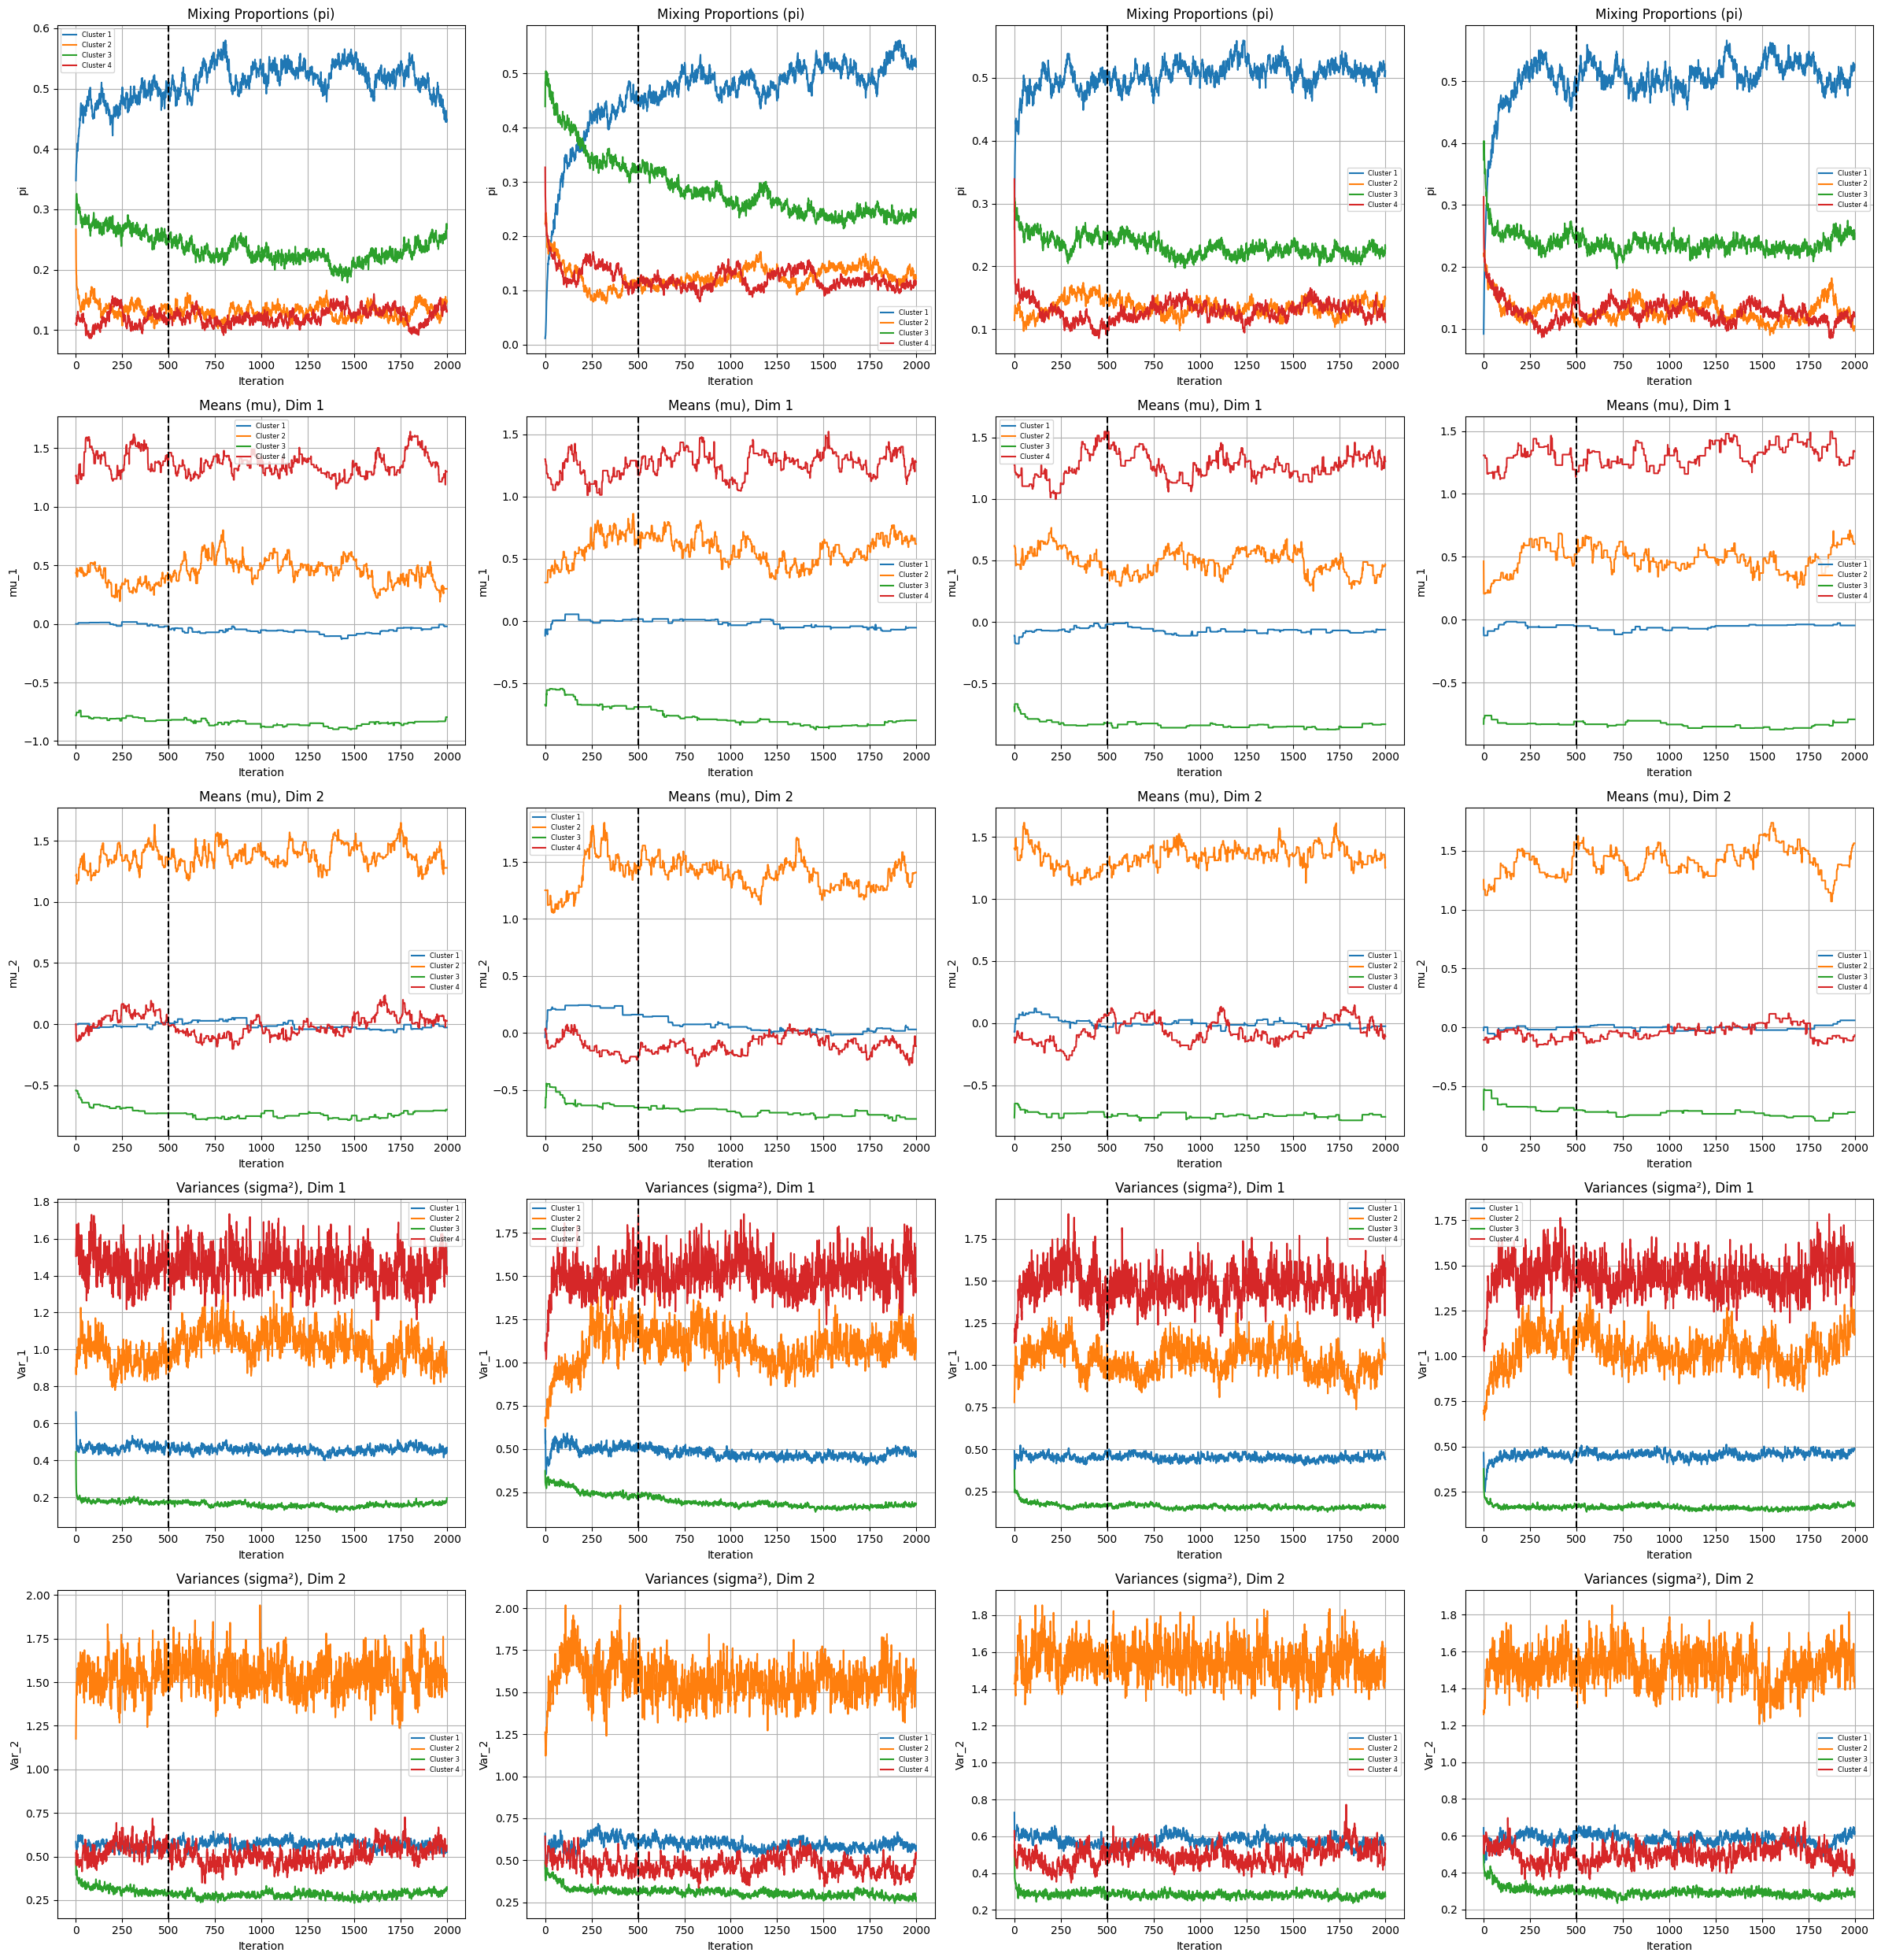

In [14]:
#h2 with initialization on corners trace plots

# Parameters
# num_runs = 4
num_iterations = 2000
K = 4  # Number of clusters
X = bmi_sbp_data[['bmi', 'sbp']].to_numpy() 
sigma_vals = [0.06,0.065,0.07,0.1]
num_runs = len(sigma_vals)
all_run_samples_h2 = []

for sig in sigma_vals:
    print(f"Running Gibbs Sampler for sigma = {sig}")
    run_samples = bayesian_repulsive_randomwalk(X, K, num_iterations, h2, 0, sig, mu = corners)
    all_run_samples_h2.append(run_samples)

# --- Trace Plots for All Runs with Burn-in Indicator ---
fig_trace, axes_trace = plt.subplots(5, num_runs, figsize=(6 * num_runs, 25))
for run in range(num_runs):
    run_samples = all_run_samples_h2[run]
    plot_trace(run_samples, K, axes_trace[:, run], burn_in=500)
plt.tight_layout()
plt.show()




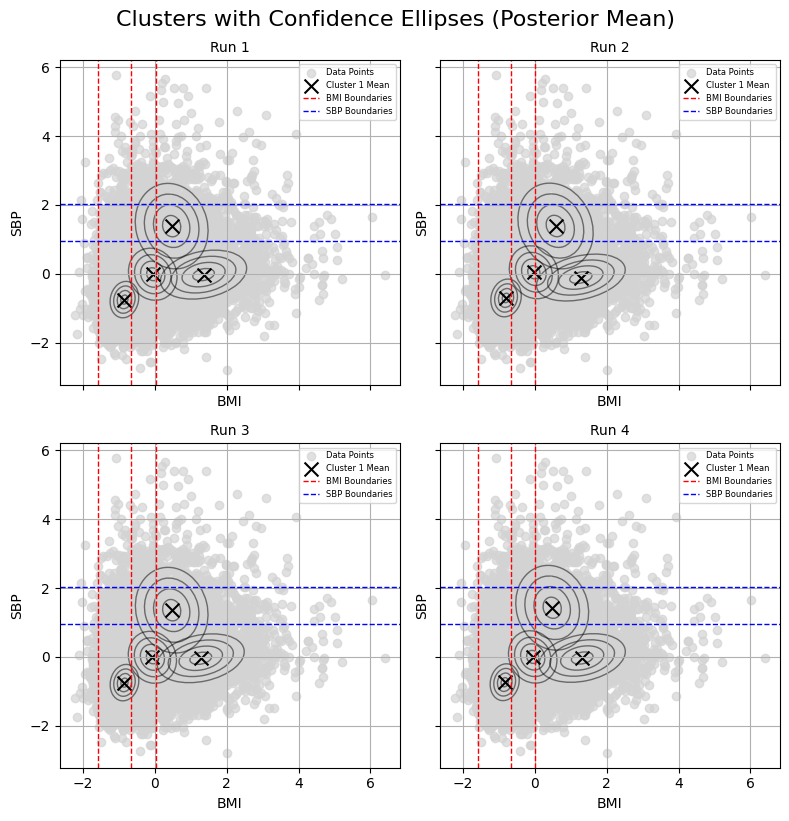

In [15]:
ellipse_mean(all_run_samples_h2, X, bmi_bounds, sbp_bounds, burn_in=500)

In [37]:
def mu_distance_trace(mu_samples, mode='min'):
    """
    Computes a trace of distance statistics (min, mean, max) between cluster means.

    Parameters:
        mu_samples: ndarray of shape (T, K, p)
        mode: str, 'min', 'mean', or 'max'

    Returns:
        trace: ndarray of shape (T,)
    """
    trace = []
    for mu in mu_samples:
        if mu.ndim == 1:
            mu = mu.reshape(-1, 1)  # Convert 1D array to 2D if necessary
        elif mu.ndim == 2 and mu.shape[1] == 1:
            mu = mu.reshape(-1, 2)  # Ensure it has at least two columns
        dists = pdist(mu)  # Compute pairwise distances
        if mode == 'min':
            trace.append(np.min(dists))
        elif mode == 'mean':
            trace.append(np.mean(dists))
        elif mode == 'max':
            trace.append(np.max(dists))
        else:
            raise ValueError("mode must be 'min', 'mean', or 'max'")
    return np.array(trace)  # Return the trace array directly
# === Extract mu samples ===
mu_rep1 = np.array([np.array([s[1] for s in run]) for run in all_run_samples_h1])
mu_rep2 = np.array([np.array([s[1] for s in run]) for run in all_run_samples_h2])
mu_norep = np.array([np.array([s[1] for s in run]) for run in all_run_samples])
# === Compute distance traces ===
dist_min_rep1 = mu_distance_trace(mu_rep1, mode='min')
dist_mean_rep1 = mu_distance_trace(mu_rep1, mode='mean')

dist_min_rep2 = mu_distance_trace(mu_rep2, mode='min')
dist_mean_rep2 = mu_distance_trace(mu_rep2, mode='mean')

dist_min_norep = mu_distance_trace(mu_norep, mode='min')
dist_mean_norep = mu_distance_trace(mu_norep, mode='mean')

# === Plotting ===
plt.figure(figsize=(14, 5))

# --- Minimum Distance Trace ---
plt.subplot(1, 2, 1)
plt.plot(dist_min_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_min_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_min_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Minimum Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Min Distance')
plt.legend()
plt.grid(True)

# --- Mean Distance Trace ---
plt.subplot(1, 2, 2)
plt.plot(dist_mean_norep, label='No Repulsion', color='tab:blue', alpha=0.7)
plt.plot(dist_mean_rep1, label='With Repulsion (h1)', color='tab:red', alpha=0.7)
plt.plot(dist_mean_rep2, label='With Repulsion (h2)', color='tab:green', alpha=0.7)
plt.title('Mean Distance Between Cluster Means')
plt.xlabel('Iteration')
plt.ylabel('Mean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

ValueError: A 2-dimensional array must be passed.